<a href="https://colab.research.google.com/github/HaiderShawl/emotion-classifier/blob/master/emotionClassifierTraining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 2.x

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
!unzip "/content/drive/MyDrive/archive.zip"

In [ ]:
import pathlib
data_dir = pathlib.Path("/content/images/train")
print(data_dir)


/content/images/train


In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

20725


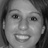

In [ ]:
happy = list(data_dir.glob('happy/*'))
PIL.Image.open(str(happy[0]))

In [ ]:
batch_size = 32
img_height = 48
img_width = 48

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 20725 files belonging to 5 classes.
Using 16580 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 20725 files belonging to 5 classes.
Using 4145 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['disgust', 'happy', 'neutral', 'sad', 'surprise']


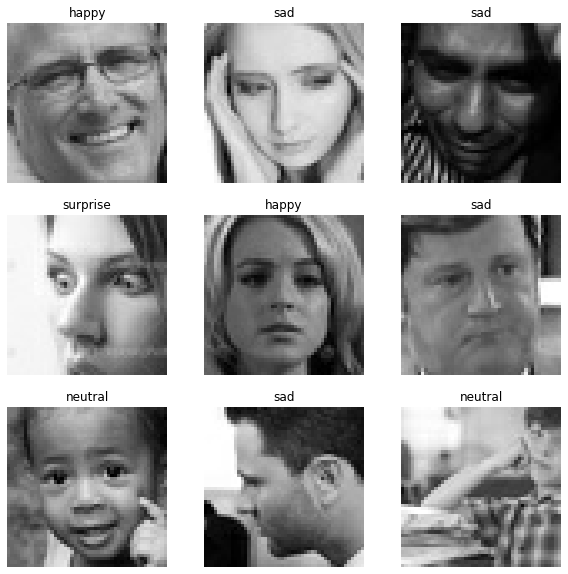

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 48, 48, 3)
(32,)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.011764707 0.9058824


In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
519/519 [==============================] - 46s 88ms/step - loss: 1.1793 - accuracy: 0.5034 - val_loss: 1.0538 - val_accuracy: 0.5696
Epoch 2/10
519/519 [==============================] - 45s 87ms/step - loss: 0.9581 - accuracy: 0.6174 - val_loss: 0.9325 - val_accuracy: 0.6248
Epoch 3/10
519/519 [==============================] - 45s 86ms/step - loss: 0.8578 - accuracy: 0.6579 - val_loss: 0.8788 - val_accuracy: 0.6408
Epoch 4/10
519/519 [==============================] - 45s 86ms/step - loss: 0.7813 - accuracy: 0.6905 - val_loss: 0.8314 - val_accuracy: 0.6695
Epoch 5/10
519/519 [==============================] - 45s 87ms/step - loss: 0.7105 - accuracy: 0.7151 - val_loss: 0.8449 - val_accuracy: 0.6601
Epoch 6/10
519/519 [==============================] - 45s 87ms/step - loss: 0.6484 - accuracy: 0.7445 - val_loss: 0.8467 - val_accuracy: 0.6707
Epoch 7/10
519/519 [==============================] - 45s 87ms/step - loss: 0.5819 - accuracy: 0.7721 - val_loss: 0.8331 - val_accuracy:

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
sunflower_path = '/content/images/validation/happy/10019.jpg'

img = keras.preprocessing.image.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

In [ ]:
# Save the entire model as a SavedModel.
model.save('/content/saved_model/my_model')

In [ ]:
!zip -r /content/file.zip /content/saved_model